In [1]:
import os
from datetime import datetime

import requests
from bs4 import BeautifulSoup

import zipfile
import pandas as pd

import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt

import math
import random
from collections import Counter

In [2]:
class TimeFrame:
    ONE_MINUTE = 'M1'
    TICK_DATA = 'T'
    TICK_DATA_LAST = 'T_LAST'
    TICK_DATA_BID = 'T_BID'
    TICK_DATA_ASK = 'T_ASK'


class Platform:
    META_TRADER = 'MT'
    GENERIC_ASCII = 'ASCII'
    EXCEL = 'XLSX'
    NINJA_TRADER = 'NT'
    META_STOCK = 'MS'


class URL:
    META_TRADER = 'https://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/'
    ASCII_1M = 'https://www.histdata.com/download-free-forex-historical-data/?/ascii/1-minute-bar-quotes/'
    ASCII_TICK_DATA = 'https://www.histdata.com/download-free-forex-historical-data/?/ascii/tick-data-quotes/'
    EXCEL = 'https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/'
    NINJA_TRADER = 'https://www.histdata.com/download-free-forex-historical-data/?/ninjatrader/1-minute-bar-quotes/'
    NINJA_TRADER_LAST_QUOTES = 'https://www.histdata.com/download-free-forex-historical-data/?/ninjatrader/tick-last-quotes/'
    NINJA_TRADER_BID_QUOTES = 'https://www.histdata.com/download-free-forex-historical-data/?/ninjatrader/tick-bid-quotes/'
    NINJA_TRADER_ASK_QUOTES = 'https://www.histdata.com/download-free-forex-historical-data/?/ninjatrader/tick-ask-quotes/'
    META_STOCK = 'https://www.histdata.com/download-free-forex-historical-data/?/metastock/1-minute-bar-quotes/'


In [3]:
def get_prefix_referer(time_frame, platform):
    if time_frame == TimeFrame.TICK_DATA and platform == Platform.GENERIC_ASCII:
        return URL.ASCII_TICK_DATA
    elif time_frame == TimeFrame.TICK_DATA_LAST and platform == Platform.NINJA_TRADER:
        return URL.NINJA_TRADER_LAST_QUOTES
    elif time_frame == TimeFrame.TICK_DATA_BID and platform == Platform.NINJA_TRADER:
        return URL.NINJA_TRADER_BID_QUOTES
    elif time_frame == TimeFrame.TICK_DATA_ASK and platform == Platform.NINJA_TRADER:
        return URL.NINJA_TRADER_ASK_QUOTES
    elif time_frame == TimeFrame.ONE_MINUTE and platform == Platform.GENERIC_ASCII:
        return URL.ASCII_1M
    elif time_frame == TimeFrame.ONE_MINUTE and platform == Platform.META_TRADER:
        return URL.META_TRADER
    elif time_frame == TimeFrame.ONE_MINUTE and platform == Platform.EXCEL:
        return URL.EXCEL
    elif time_frame == TimeFrame.ONE_MINUTE and platform == Platform.NINJA_TRADER:
        return URL.NINJA_TRADER
    elif time_frame == TimeFrame.ONE_MINUTE and platform == Platform.META_STOCK:
        return URL.META_STOCK
    else:
        raise Exception('Invalid combination of time_frame and platform.')


def get_referer(referer_prefix, pair, year, month):
    if month is not None:
        return referer_prefix + '{}/{}/{}'.format(pair.lower(), year, month)
    return referer_prefix + '{}/{}'.format(pair.lower(), year)


def download_hist_data(year='2016',
                       month=None,
                       pair='eurusd',
                       time_frame=TimeFrame.ONE_MINUTE,
                       platform=Platform.GENERIC_ASCII,
                       output_directory='.',
                       verbose=True):
    """
    Download 1-Minute FX data per month.
    :param year: Trading year. Format is 2016.
    :param month: Trading month. Format is 7 or 12.
    :param pair: Currency pair. Example: eurgbp.
    :param time_frame: M1 (one minute) or T (tick data)
    :param platform: MT, ASCII, XLSX, NT, MS
    :param output_directory: Where to dump the data.
    :return: ZIP Filename.
    """

    tick_data = time_frame.startswith('T')
    if (not tick_data) and ((int(year) >= datetime.now().year and month is None) or
                            (int(year) <= datetime.now().year - 1 and month is not None)):
        msg = 'For the current year, please specify month=7 for example.\n'
        msg += 'For the past years, please query per year with month=None.'
        raise AssertionError(msg)

    prefix_referer = get_prefix_referer(time_frame, platform)
    referer = get_referer(prefix_referer, pair.lower(), year, month)

    # Referer is the most important thing here.
    headers = {'Host': 'www.histdata.com',
               'Connection': 'keep-alive',
               'Content-Length': '104',
               'Cache-Control': 'max-age=0',
               'Origin': 'https://www.histdata.com',
               'Upgrade-Insecure-Requests': '1',
               'Content-Type': 'application/x-www-form-urlencoded',
               'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
               'Referer': referer}

    if verbose:
        print(referer)
    r1 = requests.get(referer, allow_redirects=True)
    assert r1.status_code == 200, 'Make sure the website www.histdata.com is up.'

    soup = BeautifulSoup(r1.content, 'html.parser')
    try:
        token = soup.find('input', {'id': 'tk'}).attrs['value']
        assert len(token) > 0
    except:
        raise AssertionError('There is no token. Please make sure your year/month/pair is correct.'
                             'Example is year=2016, month=7, pair=eurgbp')

    data = {'tk': token,
            'date': str(year),
            'datemonth': '{}{}'.format(year, str(month).zfill(2)) if month is not None else str(year),
            'platform': platform,
            'timeframe': time_frame,
            'fxpair': pair.upper()}
    r = requests.post(url='https://www.histdata.com/get.php',
                      data=data,
                      headers=headers)

    assert len(r.content) > 0, 'No data could be found here.'
    if verbose:
        print(data)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    if month is None:
        output_filename = 'DAT_{}_{}_{}_{}.zip'.format(platform, pair.upper(), time_frame, str(year))
    else:
        output_filename = 'DAT_{}_{}_{}_{}.zip'.format(platform, pair.upper(), time_frame,
                                                       '{}{}'.format(year, str(month).zfill(2)))
    output_filename = os.path.join(output_directory, output_filename)
    with open(output_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    if verbose:
        print('Wrote to {}'.format(output_filename))
    return output_filename


if __name__ == '__main__':
    # print(download_hist_data(year='2019', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.TICK_DATA_LAST))
    # print(download_hist_data(year='2019', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.TICK_DATA_ASK))
    # print(download_hist_data(year='2019', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.TICK_DATA_BID))
    # print(download_hist_data(year='2019', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.ONE_MINUTE))
    # print(download_hist_data(year='2019', month='6', platform=Platform.GENERIC_ASCII, time_frame=TimeFrame.TICK_DATA))
    # print(download_hist_data(year='2019', month='6', platform=Platform.EXCEL, time_frame=TimeFrame.ONE_MINUTE))
    # print(download_hist_data(year='2019', month='6', platform=Platform.META_TRADER, time_frame=TimeFrame.ONE_MINUTE))
    # print(download_hist_data(year='2019', month='6', platform=Platform.META_STOCK, time_frame=TimeFrame.ONE_MINUTE))

    # print(
    #     download_hist_data(year='2018', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.TICK_DATA_LAST))
    # print(
    #     download_hist_data(year='2018', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.TICK_DATA_ASK))
    # print(
    #     download_hist_data(year='2018', month='6', platform=Platform.NINJA_TRADER, time_frame=TimeFrame.TICK_DATA_BID))
    # print(download_hist_data(year='2018', month=None, platform=Platform.NINJA_TRADER, time_frame=TimeFrame.ONE_MINUTE))
    # print(download_hist_data(year='2018', month='2', platform=Platform.GENERIC_ASCII, time_frame=TimeFrame.TICK_DATA))
    # print(download_hist_data(year='2018', month=None, platform=Platform.EXCEL, time_frame=TimeFrame.ONE_MINUTE))
    # print(download_hist_data(year='2018', month=None, platform=Platform.META_TRADER, time_frame=TimeFrame.ONE_MINUTE))
    # print(download_hist_data(year='2018', month=None, platform=Platform.META_STOCK, time_frame=TimeFrame.ONE_MINUTE))
    pass

In [4]:
def clean_data(data_bid, first):

    N = data_bid.shape[0]
    
    Hour = []
    Min = []
    Time = []
    Date = []
    Open = []
    High = []
    Low = []
    Close = []
    Ask = []
    Volume = []
    
    Hour.append(int(data_bid["Time"][first].split(':')[0]))
    Min.append(int(data_bid["Time"][first].split(':')[1]))
    Time.append(data_bid["Time"][first])
    Date.append(data_bid["Date"][first])
    Open.append(data_bid["Open"][first])
    Close.append(data_bid["Close"][first])
    High.append(data_bid["High"][first])
    Low.append(data_bid["Low"][first])
    Volume.append(data_bid["Volume"][first])
    
    
    for i in range(first+1,N):
        H = int(data_bid["Time"][i].split(':')[0])
        M = int(data_bid["Time"][i].split(':')[1])
        if Min[-1] == 59:
            M = M+60
        dis = M - Min[-1]
        for j in range(dis):
            Hour.append(int(data_bid["Time"][i].split(':')[0]))
            Min.append(int(data_bid["Time"][i].split(':')[1]))
            Time.append(data_bid["Time"][i])
            Date.append(data_bid["Date"][i])
            Open.append(data_bid["Open"][i])
            Close.append(data_bid["Close"][i])
            High.append(data_bid["High"][i])
            Low.append(data_bid["Low"][i])
            Volume.append(data_bid["Volume"][i])
            
    d = pd.DataFrame(list(zip(Date, Time, Open, High, Low, Close, Volume)),
            columns=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'])
    
    return(d)

In [5]:
def time_convertor(data_bid, period):
    N = data_bid.shape[0]
    Time = []
    Date = []
    Open = []
    High = []
    Low = []
    Close = []
    Ask = []
    Volume = []
    for i in range(0,N - period,period):
        Time.append(data_bid["Date"][i] + ' ' + data_bid["Time"][i])
        Date.append(data_bid["Date"][i])
        Open.append(data_bid["Open"][i])
        Close.append(data_bid["Close"][i+period-1])
        High.append(max(data_bid["High"][i:i+period]))
        Low.append(min(data_bid["Low"][i:i+period]))
        Volume.append(sum(data_bid["Volume"][i:i+period]))
    return(Time, Date, Open, High, Low, Close, Volume)

In [6]:
def preprocess(data,period):    
    Time, Date, Open, High, Low, Close, Volume = time_convertor(data,period)

    week_day = []
    for i in range(len(Time)):
        day = Date[i].split('.')[2]
        month = Date[i].split('.')[1]
        year = Date[i].split('.')[0]
        week_day.append(calendar.weekday(int(year), int(month), int(day)))

    Time = np.array(Time)
    Open = np.array(Open)  
    High =  np.array (High)
    Low =  np.array(Low)
    Close =  np.array(Close)
    #Ask = np.array(Ask)
    week_day = np.array(week_day)

    l = np.where(np.logical_or(week_day == 5, week_day == 6))

    Time = np.delete(Time, l) 
    Date = np.delete(Date, l)  
    Open = np.delete(Open, l)  
    High =  np.delete (High, l)
    Low =  np.delete(Low, l)
    Close =  np.delete(Close, l)
    Volume = np.delete(Volume, l)
    #Ask = np.delete(Ask, l)

    data = pd.DataFrame(list(zip(Time, Open, High, Low, Close, Volume)),
                columns=['Time','Open', 'High', 'Low', 'Close', 'Volume'])
    
    #return(data, Time, Date, Open, High, Low, Close, Volume)
    return(data)

In [80]:
def construct_data(pair, start_year, end_year, period):    
    time_frame = "M1"
    years = np.arange(start_year,end_year + 1)
    df = pd.DataFrame(columns=['Time','Open', 'High', 'Low', 'Close', 'Volume'])
    now = datetime.now()
    curr = os.getcwd()
    if not os.path.split(curr)[1]=='FX_data': os.chdir("./FX_data/")   
    for year in years:
        first = 0
        if year == now.year:
            for month in np.arange(1, now.month):
                yearmonth = str(year) + str(month) if month > 9 else str(year) + '0' + str(month)
                file_name ='DAT_MT_{}_{}_{}.zip'.format(pair.upper(), time_frame, yearmonth)
                file_name_csv = 'DAT_MT_{}_{}_{}.csv'.format(pair.upper(), time_frame, yearmonth)
                if not os.path.exists(file_name):
                    download_hist_data(year=year, month=month,pair=pair, platform=Platform.META_TRADER, time_frame=TimeFrame.ONE_MINUTE, verbose=False)
                archive = zipfile.ZipFile(file_name, 'r')
                data = pd.read_csv(archive.open(file_name_csv), header=None)
                data.columns = ['Date','Time','Open','High','Low','Close','Volume']
                if year == start_year and month == 1:
                    while not int(data["Time"][first].split(':')[1]) == 0:
                        first+=1
                data = clean_data(data,first)
                data = preprocess(data,period)
                df = pd.concat([df,data],ignore_index=True,sort=False, axis=0)            
        else:
            file_name = 'DAT_MT_{}_{}_{}.zip'.format(pair.upper(), time_frame,year)
            file_name_csv = 'DAT_MT_{}_{}_{}.csv'.format(pair.upper(), time_frame,year)
            if not os.path.exists(file_name):
                download_hist_data(year=year,pair=pair, platform=Platform.META_TRADER, time_frame=TimeFrame.ONE_MINUTE, verbose=False)
            archive = zipfile.ZipFile(file_name, 'r')
            data = pd.read_csv(archive.open(file_name_csv), header=None)
            data.columns = ['Date','Time','Open','High','Low','Close','Volume']
            #if year == start_year:
            while not int(data["Time"][first].split(':')[1]) == 0:
                first+=1
            data = clean_data(data,first)
            data = preprocess(data,period)
            df = pd.concat([df,data],ignore_index=True,sort=False, axis=0)
    return(df)

In [70]:
pair = "gbpjpy"
#start_year = 2017
year = 2018
period = 30
first = 0
time_frame = "M1"

In [312]:
pair = "gbpjpy"
start_date = 2009
end_date = 2018
freq = 5

file_csv = '{}_{}_{}_{}.csv'.format(pair.upper(), freq, start_date, end_date)
file_csv_temp = '{}_{}_{}_{}Temp.csv'.format(pair.upper(), freq, start_date, end_date)
file_csv_clean = '{}_{}_{}_{}Clean.csv'.format(pair.upper(), freq, start_date, end_date)

curr = os.getcwd()
if not os.path.split(curr)[1]=='FX_data': os.chdir("./FX_data/")
if os.path.exists(file_csv_clean):
    data = pd.read_csv(file_csv_clean)
else:
    data = construct_data(pair,start_date,end_date,freq)

In [313]:
Close = data["Close"]
High = data["High"]
Low = data["Low"]
Time = data["Time"]
Volume = data["Volume"]

In [314]:
sample = random.sample(list(Close.values), 1000)

pip_list = []
for i in range(1000):
    pip_list.append(math.pow(10,-len(str(sample[i]).split('.')[1])+1))

c = Counter(pip_list)
PIP_RATIO, count = c.most_common()[0]
INVERSE_PIP_RATIO = 1/PIP_RATIO
MARGIN = 4

def sma(series, window=50, min_periods=0):
    # Center must always be False to circumvent look-ahead bias
    sma = series.rolling(window=window, min_periods=min_periods,
                         center=False).mean()
    sma.rename(index='SMA', inplace=True)
    return(sma)

def stoc(df, col_labels=('Low', 'High', 'Close'),
         k_smooth=5, d_smooth=5, window=15, min_periods=0):
    # Should col_labels be a dictionary? i.e. {'low':'Low', ...}
    low = df[col_labels[0]]
    high = df[col_labels[1]]
    close = df[col_labels[2]]

    # min_periods should always be 0 for this
    lowest_low = low.rolling(window=window, min_periods=window).min()
    highest_high = high.rolling(window=window, min_periods=window).max()

    k = (close - lowest_low) / (highest_high - lowest_low) * 100

    if min_periods > 0:
        k[:min_periods] = np.NaN

    if k_smooth != 0:
        k = sma(k, window=k_smooth)
    d = sma(k, window=d_smooth)
   # return pd.DataFrame({'%K': k, '%D': d})

    return(k)

def sstoc(df, col_labels=('Low', 'High', 'Close'),
          k_smooth=5, d_smooth=5, window=15):
    return stoc(df, col_labels=col_labels, k_smooth=k_smooth,
    d_smooth=d_smooth, window=window, min_periods=0)

def slow_stochastic(data,Kperiod,Dperiod): 
    not_null = 0
    l, h = pd.rolling_min(data["Low"], Kperiod), pd.rolling_max(data["High"], Kperiod)
    k = 100 * (data["Close"] - l) / (h - l) 
    #k = pd.rolling_mean(k, Dperiod)
    #if k_smooth != 0:
    k = sma(k, window=Dperiod)
 #   d = sma(k, window=d_smooth)
    for i in range(19,k.shape[0]):
        if not pd.isnull(k[i]):
            not_null = k[i]
        else:
            k[i] = not_null    
    return(k)

def stochastic_crossover(i, stochastic):
    if stochastic[i]>=50.0 and stochastic[i-1]<50.0:
        return(1)
    elif stochastic[i]<50.0 and stochastic[i-1]>=50.0:
        return(2)
    else:
        return(0)

def distant(first,second, Distance = 50):
    if((first-second)> Distance * PIP_RATIO):
        return True
    else:
        return False

class position:
    def __init__(self):
        self.have_position = False
        self.open_t = []
        self.profitloss = []
        self.max_profit = []
        self.max_loss = []
        self.shooting_d = []
        self.trigger_d = []
        self.returns = []
        self.accumPL = []
        self.volume = []
        self.index = []
    def take_position(self, get_positopn_type, uptrend, cum_pips, price, shooting_delta, trigger_delta, time, limit, stop, trailing_stop, i):
        if (self.have_position):
            if get_positopn_type == "Buy" and self.position_type == "Short":
                profit = (self.open_price - price) * INVERSE_PIP_RATIO
                cum_pips += profit
                
                self.accumPL.append(cum_pips)
                self.open_t.append(self.open_time)
                self.profitloss.append(profit)
                self.max_profit.append((self.open_price - self.low)*INVERSE_PIP_RATIO/self.open_price)
                self.max_loss.append((self.open_price - self.high)*INVERSE_PIP_RATIO/self.open_price)
                self.shooting_d.append(self.shooting_delta)
                self.trigger_d.append(self.trigger_delta)
                self.returns.append(list((Close[i-31:i-1] - Close[i-30:i])*INVERSE_PIP_RATIO/Close[i-31:i-1]))
                
               # self.volume.append(list((Volume[i-31:i-1] - Volume[i-30:i])*INVERSE_PIP_RATIO/Volume[i-31:i-1]))
                
                
                print("Short position opened %s price %.5f closed %s profit %.5f pips"%(self.open_time, self.open_price, time, profit))
                print("Maximum Profit: ", (self.open_price - self.low)*INVERSE_PIP_RATIO)
                print("Maximum Loss: ", (self.open_price - self.high)*INVERSE_PIP_RATIO)
               # print("Shooting Delta: ", self.shooting_delta)
               # print("Trigger Delta: ", self.trigger_delta)
               # print("Ratio of Deltas: ", self.shooting_delta/self.trigger_delta)
                print("Cumulative Pips is :",cum_pips)
                print("*************************************************")
                self.open_price = price
                self.position_type = "Long"
                self.open_time = time
                self.limit_price = limit
                self.stop_loss = stop
                self.trailing_stop = trailing_stop
                self.trailing_price = price
                self.high = 0
                self.low = 10000
                self.shooting_delta = shooting_delta
                self.trigger_delta = trigger_delta
                uptrend = True
                self.index.append(i)
                #print("Buy at %s price %.5f, limit order at %.5f, stop loss at %.5f with volume difference of %.2f"%(time, price,self.limit_price, self.stop_loss,(Volume[i] - Volume[i-1])*INVERSE_PIP_RATIO/Volume[i-1]))
                print("Buy at %s price %.5f, limit order at %.5f, stop loss at %.5f"%(time, price,self.limit_price, self.stop_loss))
                #print("*************************************************")
            elif get_positopn_type == "Sell" and self.position_type == "Long":
                profit = (price - self.open_price) * INVERSE_PIP_RATIO
                cum_pips += profit
               
                self.accumPL.append(cum_pips)
                self.open_t.append(self.open_time)
                self.profitloss.append(profit)
                self.max_profit.append((self.high - self.open_price)*INVERSE_PIP_RATIO/self.open_price)
                self.max_loss.append((self.low - self.open_price)*INVERSE_PIP_RATIO/self.open_price)
                self.shooting_d.append(self.shooting_delta)
                self.trigger_d.append(self.trigger_delta)
                self.returns.append(list((Close[i-31:i-1] - Close[i-30:i])*INVERSE_PIP_RATIO/Close[i-31:i-1]))
              #  self.volume.append(list((Volume[i-31:i-1] - Volume[i-30:i])*INVERSE_PIP_RATIO/Volume[i-31:i-1]))
                
                print("Long position opened %s price %.5f closed %s profit %.5f pips"%(self.open_time, self.open_price, time, profit))
                print("Maximum Profit: ", (self.high - self.open_price)*INVERSE_PIP_RATIO)
                print("Maximum Loss: ", (self.low - self.open_price)*INVERSE_PIP_RATIO)
               # print("Shooting Delta: ", self.shooting_delta)
               # print("Trigger Delta: ", self.trigger_delta)
               # print("Ratio of Deltas: ", self.shooting_delta/self.trigger_delta)
                print("Cumulative Pips is :",cum_pips)
                print("*************************************************")
                self.open_price = price
                self.position_type = "Short"
                self.open_time = time
                self.limit_price = limit
                self.stop_loss = stop
                self.trailing_stop = trailing_stop
                self.trailing_price = price
                self.high = 0
                self.low = 10000
                self.shooting_delta = shooting_delta
                self.trigger_delta = trigger_delta
                uptrend = False
                self.index.append(i)
                #print("Sell at %s price %.5f, limit order at %.5f, stop loss at %.5f with volume difference of %.2f"%(time, price, self.limit_price, self.stop_loss, (Volume[i] - Volume[i-1])*INVERSE_PIP_RATIO/Volume[i-1]))
                print("Sell at %s price %.5f, limit order at %.5f, stop loss at %.5f"%(time, price, self.limit_price, self.stop_loss))
                #print("************************************************")
        else:
            if get_positopn_type == "Buy":
                self.open_price = price
                self.have_position = True;
                self.position_type = "Long"
                self.open_time = time
                self.limit_price = limit
                self.stop_loss = stop
                self.trailing_stop = trailing_stop
                self.trailing_price = price
                self.high = 0
                self.low = 10000
                self.shooting_delta = shooting_delta
                self.trigger_delta = trigger_delta
                self.returns.append(list((Close[i-31:i-1] - Close[i-30:i])*INVERSE_PIP_RATIO/Close[i-31:i-1]))
            #    self.volume.append(list((Volume[i-31:i-1] - Volume[i-30:i])*INVERSE_PIP_RATIO/Volume[i-31:i-1]))
                uptrend = True
                self.index.append(i)
                #print("Buy at %s price %.5f, limit order at %.5f, stop loss at %.5f with volume difference of %.2f"%(time, price, self.limit_price, self.stop_loss, (Volume[i] - Volume[i-1])*INVERSE_PIP_RATIO/Volume[i-1]))
                print("Buy at %s price %.5f, limit order at %.5f, stop loss at %.5f"%(time, price, self.limit_price, self.stop_loss))
                
                #print("*************************************************")
            elif get_positopn_type == "Sell":
                self.open_price = price
                self.have_position=True; 
                self.position_type = "Short"
                self.open_time = time
                self.limit_price = limit
                self.stop_loss = stop
                self.trailing_stop = trailing_stop
                self.trailing_price = price
                self.high = 0
                self.low = 10000
                self.shooting_delta = shooting_delta
                self.trigger_delta = trigger_delta
                self.returns.append(list((Close[i-31:i-1] - Close[i-30:i])*INVERSE_PIP_RATIO/Close[i-31:i-1]))
            #    self.volume.append(list((Volume[i-31:i-1] - Volume[i-30:i])*INVERSE_PIP_RATIO/Volume[i-31:i-1]))
                uptrend = False 
                self.index.append(i)
                #print("Sell at %s price %.5f, limit order at %.5f, stop loss at %.5f  with volume difference of %.2f"%(time, price, self.limit_price, self.stop_loss, (Volume[i] - Volume[i-1])*INVERSE_PIP_RATIO/Volume[i-1]))
                print("Sell at %s price %.5f, limit order at %.5f, stop loss at %.5f"%(time, price, self.limit_price, self.stop_loss))
                
                #print("*************************************************")
        return uptrend, cum_pips 
    
    def close_position(self, cum_pips, time, Low, High, state):
        if self.position_type == "Short":
            if High > self.high: self.high = High
            if Low < self.low: self.low = Low
            
            if Low + MARGIN * PIP_RATIO < self.limit_price:
                profit = (self.open_price - self.limit_price)*INVERSE_PIP_RATIO
                cum_pips += profit
                
                self.accumPL.append(cum_pips)
                self.open_t.append(self.open_time)
                self.profitloss.append(profit)
                self.max_profit.append((self.open_price - self.low)*INVERSE_PIP_RATIO/self.open_price)
                self.max_loss.append((self.open_price - self.high)*INVERSE_PIP_RATIO/self.open_price)
                self.shooting_d.append(self.shooting_delta)
                self.trigger_d.append(self.trigger_delta)
                
                
                print("Short position opened %s price %.5f closed %s profit %d pips"%(self.open_time, self.open_price, time, profit))
                print("Maximum Profit: ", (self.open_price - self.low)*INVERSE_PIP_RATIO)
                print("Maximum Loss: ", (self.open_price - self.high)*INVERSE_PIP_RATIO)
               # print("Shooting Delta: ", self.shooting_delta)
               # print("Trigger Delta: ", self.trigger_delta)
               # print("Ratio of Deltas: ", self.shooting_delta/self.trigger_delta)
                print("Cumulative Pips is :",cum_pips)
                print("*************************************************")
                self.low = 10000
                self.high = 0
                if state == 3:
                    state = 0
                elif state == 13:
                    state = 10
                self.have_position = False
            elif High + MARGIN * PIP_RATIO > self.stop_loss:
                profit = (self.open_price - self.stop_loss) * INVERSE_PIP_RATIO
                cum_pips += profit
                
                self.accumPL.append(cum_pips)
                self.open_t.append(self.open_time)
                self.profitloss.append(profit)
                self.max_profit.append((self.open_price - self.low)*INVERSE_PIP_RATIO/self.open_price)
                self.max_loss.append((self.open_price - self.high)*INVERSE_PIP_RATIO/self.open_price)
                self.shooting_d.append(self.shooting_delta)
                self.trigger_d.append(self.trigger_delta)
                
                
                print("Short position opened %s price %.5f closed %s profit %d pips"%(self.open_time, self.open_price, time, profit))
                print("Maximum Profit: ", (self.open_price - self.low)*INVERSE_PIP_RATIO)
                print("Maximum Loss: ", (self.open_price - self.high)*INVERSE_PIP_RATIO)
               # print("Shooting Delta: ", self.shooting_delta)
               # print("Trigger Delta: ", self.trigger_delta)
               # print("Ratio of Deltas: ", self.shooting_delta/self.trigger_delta)
                print("Cumulative Pips is :",cum_pips)
                print("*************************************************")
                self.low = 10000
                self.high = 0
                if state == 3:
                    state = 0
                elif state == 13:
                    state = 10
                self.have_position = False
                
            if self.trailing_stop > 0:
                if self.trailing_price - Low > self.trailing_stop * PIP_RATIO:
                    self.stop_loss = self.stop_loss - self.trailing_stop * PIP_RATIO
                    self.trailing_price = self.trailing_price - self.trailing_stop * PIP_RATIO
                
        else:
            if High > self.high: self.high = High
            if Low < self.low: self.low = Low
            
            if High > self.limit_price:
                profit = (self.limit_price - self.open_price) * INVERSE_PIP_RATIO
                cum_pips += profit
                
                self.accumPL.append(cum_pips)
                self.open_t.append(self.open_time)
                self.profitloss.append(profit)
                self.max_profit.append((self.high - self.open_price)*INVERSE_PIP_RATIO/self.open_price)
                self.max_loss.append((self.low - self.open_price)*INVERSE_PIP_RATIO/self.open_price)
                self.shooting_d.append(self.shooting_delta)
                self.trigger_d.append(self.trigger_delta)
                
                
                print("Long position opened %s price %.5f closed %s profit %d pips"%(self.open_time, self.open_price, time, profit))
                print("Maximum Profit: ", (self.high - self.open_price)*INVERSE_PIP_RATIO)
                print("Maximum Loss: ", (self.low - self.open_price)*INVERSE_PIP_RATIO)
               # print("Shooting Delta: ", self.shooting_delta)
               # print("Trigger Delta: ", self.trigger_delta)
               # print("Ratio of Deltas: ", self.shooting_delta/self.trigger_delta)
                print("Cumulative Pips is :",cum_pips)
                print("************************************************")
                self.low = 10000
                self.high = 0
                if state == 3:
                    state = 0
                elif state == 13:
                    state = 10
                self.have_position = False
            elif Low < self.stop_loss:
                profit = (self.stop_loss - self.open_price) * INVERSE_PIP_RATIO
                cum_pips += profit
                
                self.accumPL.append(cum_pips)
                self.open_t.append(self.open_time)
                self.profitloss.append(profit)
                self.max_profit.append((self.high - self.open_price)*INVERSE_PIP_RATIO/self.open_price)
                self.max_loss.append((self.low - self.open_price)*INVERSE_PIP_RATIO/self.open_price)
                self.shooting_d.append(self.shooting_delta)
                self.trigger_d.append(self.trigger_delta)
                #print("low")
                #print(Low)
                #print("stop loss")
                #print(self.stop_loss)
            
                print("Long position opened %s price %.5f closed %s profit %d pips"%(self.open_time, self.open_price, time, profit))
                print("Maximum Profit: ", (self.high - self.open_price)*INVERSE_PIP_RATIO)
                print("Maximum Loss: ", (self.low - self.open_price)*INVERSE_PIP_RATIO)
               # print("Shooting Delta: ", self.shooting_delta)
               # print("Trigger Delta: ", self.trigger_delta)
               # print("Ratio of Deltas: ", self.shooting_delta/self.trigger_delta)
                print("Cumulative Pips is :",cum_pips)
                print("*************************************************")
                self.low = 10000
                self.high = 0
                if state == 3:
                    state = 0
                elif state == 13:
                    state = 10
                self.have_position = False
                
            if self.trailing_stop > 0:                
                if High - self.trailing_price > self.trailing_stop * PIP_RATIO:
                    self.stop_loss =  self.stop_loss + self.trailing_stop * PIP_RATIO
                    self.trailing_price = self.trailing_price + self.trailing_stop * PIP_RATIO     
        return cum_pips, state

In [315]:
del p

In [316]:
#stochastic = slow_stochastic(data, 15, 5)
stochastic = sstoc(data)

limit = 400
stop = 600

#limit = 30
#stop = 80
trailing_stop = 100

first_min = 1000
first_max = 0
second_min = 1000
second_max = 0

distance = 100
p = position()
N = len(High)
cumpips = 0
state = -3
uptrend = False
max_value = 0
min_value = 1000
#trendprice = Close[0]
#trendprice = 1.34517
#triggerprice = Close[0]
#triggerprice = 1.36082

for i in range(N):
    #print("%s: state: %d, trend: %.5f, trigger: %.5f, shooting: %.5f, min:%.5f, max:%.5f, high:%.5f, low: %.5f, uptrend: %r "%(Time[i], state, trendprice, triggerprice, shootingprice, min_value, max_value, High[i], Low[i], uptrend))
    if p.have_position:
        cumpips, state = p.close_position(cumpips, Time[i], Low[i], High[i], state)
                
            
            #if state == 3:
            #        state = 0
             #   elif state == 13:
              #      state = 10
                    
                
        #elif p.position_type == "Long":
         #   if distant(High[i], p.open_price, (cap+2)*10):
          #      cumpips = p.close_position(cumpips, Time[i], cap)
           #     if state == 3:
            #        state = 0
             #   elif state == 13:
              #      state = 10
        
        
    if state == -3:
            if first_max < High[i]: first_max = High[i]
            if first_min > Low[i]: first_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                state = -21
                first_min = first_max
            elif SC==1:
                state = -20
                first_max = first_min
    
    elif state == -20:
            if first_max < High[i]: first_max = High[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                state = -22
                first_min = first_max
                
    elif state == -22:
            if first_min > Low[i]: first_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==1: 
                state = -24
                second_max = first_min
                
    elif state == -24:
            if second_max < High[i]: second_max = High[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                if second_max <= first_max:
                    uptrend = False
                    triggerprice = first_max
                    trendprice = first_min
                    state = 0
                else:
                    uptrend = True
                    triggerprice = first_min
                    trendprice = second_max
                    state = 0

    elif state == -21:
            if first_min > Low[i]: first_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==1: 
                state = -23
                first_max = first_min
                
    elif state == -23:
            if first_max < High[i]: first_max = High[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                state = -25
                second_min = first_max
                
    elif state == -25:
            if second_min > Low[i]: second_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                if second_min <= first_min:
                    uptrend = False
                    triggerprice = first_max
                    trendprice = second_min
                    state = 0
                else:
                    uptrend = True
                    triggerprice = first_min
                    trendprice = first_max
                    state = 0        

    elif state == 0:
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(max_value,trendprice, distance):
                triggerprice = min_value
                #min_value = High[i]
                state = 10
              
            if distant(triggerprice,min_value, distance):  
                state = 1
                max_value = min_value
        else: 
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(trendprice, min_value, distance):
                triggerprice = max_value
                #max_value = Low[i]
                state = 10
            
            if distant(max_value,triggerprice, distance):
                state = 1
                min_value = max_value
    
    elif state == 10:  
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]

            SC = stochastic_crossover(i, stochastic)
            if SC==2:
                trendprice = max_value 
               # triggerprice = min_value
                min_value = High[i]
                state = 0
            
            if distant(triggerprice,min_value, distance):
                trendprice = max_value
                state = 1
        else:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            SC = stochastic_crossover(i, stochastic)
            if SC == 1:
                trendprice = min_value
              #  triggerprice = max_value
                max_value = Low[i]
                state = 0
                
            if distant(max_value,triggerprice, distance):
                trendprice = min_value
                state = 1

    elif state == 1:
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(max_value,trendprice, distance):
                if p.have_position:
                    state = 3
                    continue                
                else:
                    state = 0
                    continue
            
            SC = stochastic_crossover(i, stochastic)
            if SC==1: 
                shootingprice = min_value
                max_value = min_value
                state = 2
        else:
            
            if max_value < High[i]: max_value=High[i]
            if min_value > Low[i]: min_value=Low[i]
            
            if distant(trendprice,min_value, distance):
                if p.have_position:
                    state = 3
                    continue 
                else:
                    state = 0
                    continue
            
            SC = stochastic_crossover(i, stochastic)
            if SC==2:
                shootingprice = max_value
                min_value = max_value
                state = 2 
    
    elif state == 2:
        
        if uptrend:
            
            if max_value < High[i]: max_value=High[i]
            if min_value > Low[i]: min_value=Low[i]
            
            if distant(max_value,trendprice, distance):
                if p.have_position:
                    triggerprice = min_value
                    state = 13
                    min_value = High[i]
                    continue
                else:
                    triggerprice = shootingprice
                    state = 10
                    min_value = High[i]
                    continue
            
            if distant(shootingprice,min_value, distance):
                limit_price = shootingprice - (distance + limit) * PIP_RATIO
               # stop_price = max_value + distance * 0.00001
                stop_price = shootingprice  - (distance - stop) * PIP_RATIO
                uptrend, cumpips = p.take_position("Sell",uptrend,cumpips,shootingprice - distance * PIP_RATIO, abs(shootingprice - trendprice)*100, abs(triggerprice - trendprice)*100, Time[i], limit_price, stop_price, trailing_stop, i)
                state = 3
                trendprice = shootingprice
                triggerprice = max_value
                continue
        else:
            if max_value<High[i]: max_value=High[i]
            if min_value>Low[i]: min_value=Low[i];
            
            if distant(trendprice, min_value, distance):
                if p.have_position:
                    triggerprice = max_value
                    state = 13
                    max_value = Low[i]
                    continue                 
                else:
                    triggerprice = shootingprice
                    state = 10
                    max_value = Low[i]
                    continue
            
            if distant(max_value,shootingprice, distance):
                limit_price = shootingprice + (distance + MARGIN + limit) * PIP_RATIO
                #stop_price = min_value - distance * 0.00001
                stop_price = shootingprice + (distance  - stop) * PIP_RATIO
                uptrend, cumpips = p.take_position("Buy",uptrend,cumpips,shootingprice + (distance + MARGIN) * PIP_RATIO, abs(shootingprice - trendprice)*100, abs(triggerprice - trendprice)*100, Time[i], limit_price, stop_price, trailing_stop, i)
                state = 3
                trendprice = shootingprice
                triggerprice = min_value
                continue
    
    elif state == 3:
        if uptrend:
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
                    
            if distant(max_value,trendprice, distance):
                triggerprice = min_value
                #min_value = High[i]
                state = 13
              
            if distant(triggerprice,min_value, distance):  
                state = 1 
        else: 
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(trendprice, min_value, distance):
                triggerprice = max_value
                #max_value = Low[i]
                state = 13
            
            if distant(max_value,triggerprice, distance):
                state = 1
                continue
    
    elif state == 13:  
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]

            SC = stochastic_crossover(i, stochastic)
            if SC==2:
                trendprice = max_value 
               # triggerprice = min_value
                min_value = High[i]
                state = 3
            
            if distant(triggerprice,min_value, distance):
                trendprice = max_value
                state = 1
                continue
        
        else:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            SC = stochastic_crossover(i, stochastic)
            if SC == 1:
                trendprice = min_value
              #  triggerprice = max_value
                max_value = Low[i]
                state = 3
                
            if distant(max_value,triggerprice, distance):
                trendprice = min_value
                state = 1 
                continue
                

Sell at 2009.01.12 03:50 price 134.72000, limit order at 130.72000, stop loss at 140.72000
Short position opened 2009.01.12 03:50 price 134.72000 closed 2009.01.13 02:30 profit 400 pips
Maximum Profit:  421.9999999999999
Maximum Loss:  -47.99999999999898
Cumulative Pips is : 400.0
*************************************************
Buy at 2009.01.15 21:55 price 133.38000, limit order at 137.38000, stop loss at 127.34000
Long position opened 2009.01.15 21:55 price 133.38000 closed 2009.01.19 08:45 profit -220.00000 pips
Maximum Profit:  240.99999999999966
Maximum Loss:  -222.99999999999898
Cumulative Pips is : 180.00000000000114
*************************************************
Sell at 2009.01.19 08:45 price 131.18000, limit order at 127.18000, stop loss at 137.18000
Short position opened 2009.01.19 08:45 price 131.18000 closed 2009.01.20 03:35 profit 400 pips
Maximum Profit:  411.00000000000136
Maximum Loss:  -43.00000000000068
Cumulative Pips is : 580.0000000000011
*********************

Short position opened 2010.01.26 04:36 price 144.40000 closed 2010.02.04 11:41 profit 400 pips
Maximum Profit:  506.9999999999993
Maximum Loss:  -281.0000000000002
Cumulative Pips is : 3344.000000000005
*************************************************
Buy at 2010.02.17 08:06 price 143.61000, limit order at 147.61000, stop loss at 137.57000
Long position opened 2010.02.17 08:06 price 143.61000 closed 2010.02.23 07:41 profit -365.00000 pips
Maximum Profit:  2.8421709430404007e-12
Maximum Loss:  -379.9999999999983
Cumulative Pips is : 2979.0000000000073
*************************************************
Sell at 2010.02.23 07:41 price 139.96000, limit order at 135.96000, stop loss at 145.96000
Short position opened 2010.02.23 07:41 price 139.96000 closed 2010.02.25 08:36 profit 400 pips
Maximum Profit:  411.00000000000136
Maximum Loss:  -31.999999999999318
Cumulative Pips is : 3379.0000000000073
*************************************************
Buy at 2010.03.12 11:16 price 138.09000, limi

Buy at 2015.02.11 03:01 price 182.80300, limit order at 186.80300, stop loss at 176.76300
Long position opened 2015.02.11 03:01 price 182.80300 closed 2015.03.13 09:56 profit -403 pips
Maximum Profit:  222.60000000000275
Maximum Loss:  -408.3999999999975
Cumulative Pips is : 6338.500000000015
*************************************************
Sell at 2015.03.18 07:41 price 177.51300, limit order at 173.51300, stop loss at 183.51300
Short position opened 2015.03.18 07:41 price 177.51300 closed 2015.04.21 12:11 profit -134.50000 pips
Maximum Profit:  263.3999999999986
Maximum Loss:  -352.1000000000015
Cumulative Pips is : 6204.000000000017
*************************************************
Buy at 2015.04.21 12:11 price 178.85800, limit order at 182.85800, stop loss at 172.81800
Long position opened 2015.04.21 12:11 price 178.85800 closed 2015.04.29 03:16 profit 400 pips
Maximum Profit:  415.50000000000296
Maximum Loss:  -39.39999999999486
Cumulative Pips is : 6604.000000000017
************

Short position opened 2017.05.26 02:46 price 143.30700 closed 2017.06.12 08:01 profit 400 pips
Maximum Profit:  404.800000000003
Maximum Loss:  -64.09999999999627
Cumulative Pips is : 12390.00000000002
*************************************************
Buy at 2017.06.28 09:31 price 144.89800, limit order at 148.89800, stop loss at 138.85800
Long position opened 2017.06.28 09:31 price 144.89800 closed 2017.08.08 18:31 profit -184.20000 pips
Maximum Profit:  287.2000000000014
Maximum Loss:  -185.59999999999945
Cumulative Pips is : 12205.800000000021
*************************************************
Sell at 2017.08.08 18:31 price 143.05600, limit order at 139.05600, stop loss at 149.05600
Short position opened 2017.08.08 18:31 price 143.05600 closed 2017.09.12 04:26 profit -221.80000 pips
Maximum Profit:  374.20000000000186
Maximum Loss:  -224.60000000000093
Cumulative Pips is : 11984.000000000022
*************************************************
Buy at 2017.09.12 04:26 price 145.27400, li

In [319]:
X = []
pl = np.array(p.profitloss)
n = len(pl)
y = np.zeros(n)
y[pl<0] = 0
y[pl>0] = 1
for i in p.index:
    price = data.iloc[i-20:i,4]
    r = (price[1:]/price[:-1].values -1).values
    r = r*10000
    X.append(list(r))
X = np.array(X)

In [320]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

In [321]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [322]:
X_test.shape

(30, 19)

In [323]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [324]:
pred = clf.predict(X_test)

In [325]:
pred

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [326]:
accuracy_score(pred, y_test)

0.6

In [327]:
y_test

array([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [328]:
cat_features = [0, 1]

In [353]:
model = CatBoostClassifier(iterations=10,
                           learning_rate=0.05,
                           depth=5)

In [354]:
model.fit(X_train, y_train)

0:	learn: 0.6894607	total: 1.25ms	remaining: 11.3ms
1:	learn: 0.6836695	total: 2.31ms	remaining: 9.25ms
2:	learn: 0.6784741	total: 3.15ms	remaining: 7.36ms
3:	learn: 0.6752669	total: 4.13ms	remaining: 6.19ms
4:	learn: 0.6712729	total: 5.25ms	remaining: 5.25ms
5:	learn: 0.6672304	total: 6.58ms	remaining: 4.39ms
6:	learn: 0.6628859	total: 7.7ms	remaining: 3.3ms
7:	learn: 0.6591012	total: 8.62ms	remaining: 2.15ms
8:	learn: 0.6545000	total: 9.34ms	remaining: 1.04ms
9:	learn: 0.6487748	total: 10.6ms	remaining: 0us


In [355]:
pred = model.predict(X_test)

In [356]:
preds_proba = model.predict_proba(X_test)

In [357]:
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

In [358]:
accuracy_score(pred, y_test)

0.6666666666666666

In [359]:
preds_proba

array([[0.4762469 , 0.5237531 ],
       [0.48894628, 0.51105372],
       [0.49822824, 0.50177176],
       [0.47421904, 0.52578096],
       [0.47888567, 0.52111433],
       [0.4786179 , 0.5213821 ],
       [0.51629228, 0.48370772],
       [0.48022062, 0.51977938],
       [0.50828489, 0.49171511],
       [0.49430938, 0.50569062],
       [0.50369234, 0.49630766],
       [0.48243872, 0.51756128],
       [0.48020369, 0.51979631],
       [0.49645075, 0.50354925],
       [0.50716748, 0.49283252],
       [0.48083215, 0.51916785],
       [0.49413365, 0.50586635],
       [0.4967533 , 0.5032467 ],
       [0.48436198, 0.51563802],
       [0.48766687, 0.51233313],
       [0.47961861, 0.52038139],
       [0.49560627, 0.50439373],
       [0.4783128 , 0.5216872 ],
       [0.50128318, 0.49871682],
       [0.50644833, 0.49355167],
       [0.48860819, 0.51139181],
       [0.48824142, 0.51175858],
       [0.48272324, 0.51727676],
       [0.47635254, 0.52364746],
       [0.48976925, 0.51023075]])

In [360]:
preds_raw

array([ 0.09508397,  0.04422207,  0.00708706,  0.10321536,  0.08450758,
        0.08558059, -0.0651922 ,  0.07915884, -0.0331426 ,  0.02276345,
       -0.01476963,  0.07027404,  0.07922665,  0.01419725, -0.02867189,
        0.07670898,  0.02346648,  0.01298698,  0.0625725 ,  0.04934255,
        0.08157076,  0.01757538,  0.08680328, -0.00513272, -0.02579477,
        0.04557514,  0.047043  ,  0.06913458,  0.09466047,  0.04092872])

In [361]:
pred

array([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.])

In [362]:
y_test

array([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [135]:
y = np.zeros(63)

In [136]:
y[pl<0] = -1

In [137]:
y[pl>0] = 1

In [158]:
X = []

In [156]:
r = r*10000

In [159]:
X.append(list(r))

In [160]:
X

[[8.391181630940103,
  11.432926829268997,
  -13.703844689760825,
  -15.247388884652713,
  10.68947087119243,
  2.2881549843623006,
  -31.264297697117804,
  -42.07144496289894,
  1.536334306344589,
  3.0721966205859985,
  17.65970515970494,
  -66.68199586111756,
  -54.78395061728425,
  4.655132283342134,
  0.7754943776672185,
  15.508684863523303,
  5.41963456178296,
  -26.309680414764447,
  7.7585538055724435]]

In [115]:
i = 535

In [118]:
price = data.iloc[i-20:i,4]

In [119]:
price

515    131.09
516    131.20
517    131.35
518    131.17
519    130.97
520    131.11
521    131.14
522    130.73
523    130.18
524    130.20
525    130.24
526    130.47
527    129.60
528    128.89
529    128.95
530    128.96
531    129.16
532    129.23
533    128.89
534    128.99
Name: Low, dtype: float64

In [139]:
r = (price[1:]/price[:-1].values -1).values

In [120]:
price[:-1] / price[1:].values - 1

515   -0.000838
516   -0.001142
517    0.001372
518    0.001527
519   -0.001068
520   -0.000229
521    0.003136
522    0.004225
523   -0.000154
524   -0.000307
525   -0.001763
526    0.006713
527    0.005509
528   -0.000465
529   -0.000078
530   -0.001548
531   -0.000542
532    0.002638
533   -0.000775
Name: Low, dtype: float64

In [106]:
data.iloc[115034,:]

Unnamed: 0              115034
Time          2018.11.15 04:37
Open                   145.313
High                   145.313
Low                    144.873
Close                   145.04
Volume                       0
Name: 115034, dtype: object

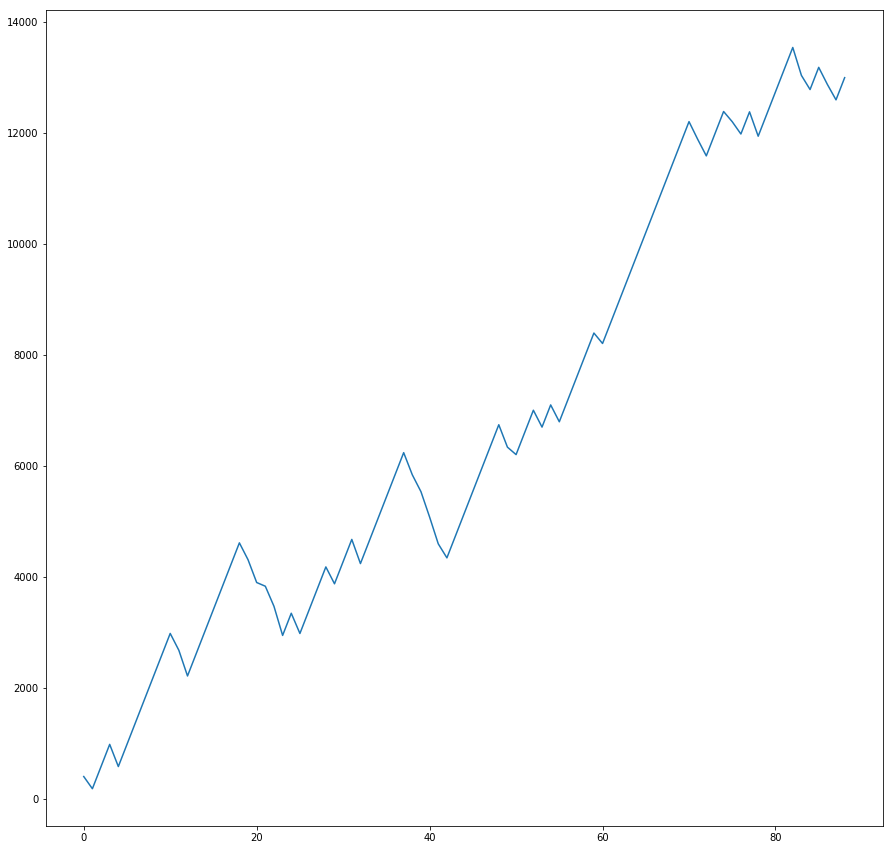

In [317]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
ax.plot(p.accumPL)

In [31]:
capital = 10000
lot_amount = INVERSE_PIP_RATIO*10
lots = capital / (lot_amount * 10)

for i in range(len(p.profitloss)):
    capital = capital + lot_amount* lots * p.profitloss[i] * PIP_RATIO
    print(capital)
    lots = capital / (lot_amount * 10)

14000.0
10920.000000000015
15288.00000000002
21403.200000000026
12841.920000000016
17978.688000000024
25170.16320000003
35238.22848000005
49333.51987200007
69066.9278208001
96693.69894912015
67298.8144685877
36139.46336963163
50595.24871748428
70833.348204478
99166.68748626919
138833.36248077685
194366.7074730876
272113.3904623226
189390.91976177678
111551.25173968679
104077.31787312792
66401.32880305557
31540.631181451397
44156.88365403196
28039.621120310396
39255.46956843455
54957.65739580837
76940.72035413171
53550.74136647573
74971.03791306603
104959.45307829244
59239.11531738846
82934.76144434384
116108.66602208136
162552.13243091392
227572.98540327948
318602.17956459126
191161.30773875475
133048.27018617344
72178.68657599925
37359.688171737325
27907.687064287777
39070.76189000289
54699.06664600405
76578.69330440566
107210.17062616794
150094.2388766351
210131.93442728912
125238.63291866447
108394.03679110447
151751.65150754625
212452.31211056476
147866.80922895324
207013.532920534

In [52]:
#stochastic = slow_stochastic(data, 15, 5)
stochastic = sstoc(data)

limit = 300
stop = 800

#limit = 30
#stop = 80
trailing_stop = 0

first_min = 1000
first_max = 0
second_min = 1000
second_max = 0

distance = 80
p = position()
N = len(High)
cumpips = 0
state = -3
uptrend = False
max_value = 0
min_value = 1000
#trendprice = Close[0]
#trendprice = 1.34517
#triggerprice = Close[0]
#triggerprice = 1.36082

for i in range(N):
    #print("%s: state: %d, trend: %.5f, trigger: %.5f, shooting: %.5f, min:%.5f, max:%.5f, high:%.5f, low: %.5f, uptrend: %r "%(Time[i], state, trendprice, triggerprice, shootingprice, min_value, max_value, High[i], Low[i], uptrend))
    if p.have_position:
        cumpips, state = p.close_position(cumpips, Time[i], Low[i], High[i], state)
                
            
            #if state == 3:
            #        state = 0
             #   elif state == 13:
              #      state = 10
                    
                
        #elif p.position_type == "Long":
         #   if distant(High[i], p.open_price, (cap+2)*10):
          #      cumpips = p.close_position(cumpips, Time[i], cap)
           #     if state == 3:
            #        state = 0
             #   elif state == 13:
              #      state = 10
        
        
    if state == -3:
            if first_max < High[i]: first_max = High[i]
            if first_min > Low[i]: first_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                state = -21
                first_min = first_max
            elif SC==1:
                state = -20
                first_max = first_min
    
    elif state == -20:
            if first_max < High[i]: first_max = High[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                state = -22
                first_min = first_max
                
    elif state == -22:
            if first_min > Low[i]: first_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==1: 
                state = -24
                second_max = first_min
                
    elif state == -24:
            if second_max < High[i]: second_max = High[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                if second_max <= first_max:
                    uptrend = False
                    triggerprice = first_max
                    trendprice = first_min
                    state = 0
                else:
                    uptrend = True
                    triggerprice = first_min
                    trendprice = second_max
                    state = 0

    elif state == -21:
            if first_min > Low[i]: first_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==1: 
                state = -23
                first_max = first_min
                
    elif state == -23:
            if first_max < High[i]: first_max = High[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                state = -25
                second_min = first_max
                
    elif state == -25:
            if second_min > Low[i]: second_min = Low[i]
                
            SC = stochastic_crossover(i, stochastic)
            if SC==2: 
                if second_min <= first_min:
                    uptrend = False
                    triggerprice = first_max
                    trendprice = second_min
                    state = 0
                else:
                    uptrend = True
                    triggerprice = first_min
                    trendprice = first_max
                    state = 0        

    elif state == 0:
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(max_value,trendprice, distance):
                triggerprice = min_value
                #min_value = High[i]
                state = 10
              
            if distant(triggerprice,min_value, distance):  
                state = 1
                max_value = min_value
        else: 
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(trendprice, min_value, distance):
                triggerprice = max_value
                #max_value = Low[i]
                state = 10
            
            if distant(max_value,triggerprice, distance):
                state = 1
                min_value = max_value
    
    elif state == 10:  
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]

            SC = stochastic_crossover(i, stochastic)
            if SC==2:
                trendprice = max_value 
               # triggerprice = min_value
                min_value = High[i]
                state = 0
            
            if distant(triggerprice,min_value, distance):
                trendprice = max_value
                state = 1
        else:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            SC = stochastic_crossover(i, stochastic)
            if SC == 1:
                trendprice = min_value
              #  triggerprice = max_value
                max_value = Low[i]
                state = 0
                
            if distant(max_value,triggerprice, distance):
                trendprice = min_value
                state = 1

    elif state == 1:
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(max_value,trendprice, distance):
                if p.have_position:
                    state = 3
                    continue                
                else:
                    state = 0
                    continue
            
            SC = stochastic_crossover(i, stochastic)
            if SC==1: 
                shootingprice = min_value
                max_value = min_value
                state = 2
        else:
            
            if max_value < High[i]: max_value=High[i]
            if min_value > Low[i]: min_value=Low[i]
            
            if distant(trendprice,min_value, distance):
                if p.have_position:
                    state = 3
                    continue 
                else:
                    state = 0
                    continue
            
            SC = stochastic_crossover(i, stochastic)
            if SC==2:
                shootingprice = max_value
                min_value = max_value
                state = 2 
    
    elif state == 2:
        
        if uptrend:
            
            if max_value < High[i]: max_value=High[i]
            if min_value > Low[i]: min_value=Low[i]
            
            if distant(max_value,trendprice, distance):
                if p.have_position:
                    triggerprice = min_value
                    state = 13
                    min_value = High[i]
                    continue
                else:
                    triggerprice = shootingprice
                    state = 10
                    min_value = High[i]
                    continue
            
            if distant(shootingprice,min_value, distance):
                limit_price = shootingprice - (distance + limit) * PIP_RATIO
               # stop_price = max_value + distance * 0.00001
                stop_price = shootingprice  - (distance - stop) * PIP_RATIO
                uptrend, cumpips = p.take_position("Sell",uptrend,cumpips,shootingprice - distance * PIP_RATIO, abs(shootingprice - trendprice)*100, abs(triggerprice - trendprice)*100, Time[i], limit_price, stop_price, trailing_stop, i)
                state = 3
                trendprice = shootingprice
                triggerprice = max_value
                continue
        else:
            if max_value<High[i]: max_value=High[i]
            if min_value>Low[i]: min_value=Low[i];
            
            if distant(trendprice, min_value, distance):
                if p.have_position:
                    triggerprice = max_value
                    state = 13
                    max_value = Low[i]
                    continue                 
                else:
                    triggerprice = shootingprice
                    state = 10
                    max_value = Low[i]
                    continue
            
            if distant(max_value,shootingprice, distance):
                limit_price = shootingprice + (distance + MARGIN + limit) * PIP_RATIO
                #stop_price = min_value - distance * 0.00001
                stop_price = shootingprice + (distance  - stop) * PIP_RATIO
                uptrend, cumpips = p.take_position("Buy",uptrend,cumpips,shootingprice + (distance + MARGIN) * PIP_RATIO, abs(shootingprice - trendprice)*100, abs(triggerprice - trendprice)*100, Time[i], limit_price, stop_price, trailing_stop, i)
                state = 3
                trendprice = shootingprice
                triggerprice = min_value
                continue
    
    elif state == 3:
        if uptrend:
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
                    
            if distant(max_value,trendprice, distance):
                triggerprice = min_value
                #min_value = High[i]
                state = 13
              
            if distant(triggerprice,min_value, distance):  
                state = 1 
        else: 
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            if distant(trendprice, min_value, distance):
                triggerprice = max_value
                #max_value = Low[i]
                state = 13
            
            if distant(max_value,triggerprice, distance):
                state = 1
                continue
    
    elif state == 13:  
        if uptrend:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]

            SC = stochastic_crossover(i, stochastic)
            if SC==2:
                trendprice = max_value 
               # triggerprice = min_value
                min_value = High[i]
                state = 3
            
            if distant(triggerprice,min_value, distance):
                trendprice = max_value
                state = 1
                continue
        
        else:
            
            if max_value < High[i]: max_value = High[i]
            if min_value > Low[i]: min_value = Low[i]
            
            SC = stochastic_crossover(i, stochastic)
            if SC == 1:
                trendprice = min_value
              #  triggerprice = max_value
                max_value = Low[i]
                state = 3
                
            if distant(max_value,triggerprice, distance):
                trendprice = min_value
                state = 1 
                continue
                

Sell at 2009.01.13 15:00 price 128.97000, limit order at 125.97000, stop loss at 136.97000
Short position opened 2009.01.13 15:00 price 128.97000 closed 2009.01.15 20:30 profit -401.00000 pips
Maximum Profit:  -6.000000000000227
Maximum Loss:  -422.999999999999
Cumulative Pips is : -400.9999999999991
*************************************************
Buy at 2009.01.15 20:30 price 132.98000, limit order at 135.98000, stop loss at 124.94000
Long position opened 2009.01.15 20:30 price 132.98000 closed 2009.01.20 14:00 profit -804 pips
Maximum Profit:  281.0000000000002
Maximum Loss:  -812.9999999999995
Cumulative Pips is : -1204.9999999999998
*************************************************
Sell at 2009.01.21 03:30 price 123.17000, limit order at 120.17000, stop loss at 131.17000
Short position opened 2009.01.21 03:30 price 123.17000 closed 2009.01.21 11:00 profit 300 pips
Maximum Profit:  371.9999999999999
Maximum Loss:  -176.0000000000005
Cumulative Pips is : -904.9999999999998
********

Buy at 2012.06.07 08:01 price 123.77900, limit order at 126.77900, stop loss at 115.73900
Long position opened 2012.06.07 08:01 price 123.77900 closed 2012.09.14 05:31 profit 300 pips
Maximum Profit:  302.50000000000057
Maximum Loss:  -296.9999999999999
Cumulative Pips is : -583.600000000011
************************************************
Sell at 2012.10.08 11:01 price 125.15300, limit order at 122.15300, stop loss at 133.15300
Short position opened 2012.10.08 11:01 price 125.15300 closed 2012.11.20 20:01 profit -531.30000 pips
Maximum Profit:  42.99999999999926
Maximum Loss:  -532.5999999999993
Cumulative Pips is : -1114.9000000000128
*************************************************
Buy at 2012.11.20 20:01 price 130.46600, limit order at 133.46600, stop loss at 122.42600
Long position opened 2012.11.20 20:01 price 130.46600 closed 2012.12.12 03:01 profit 300 pips
Maximum Profit:  303.2999999999987
Maximum Loss:  -47.800000000000864
Cumulative Pips is : -814.9000000000128
***********

Buy at 2016.11.08 13:01 price 130.29100, limit order at 133.29100, stop loss at 122.25100
Long position opened 2016.11.08 13:01 price 130.29100 closed 2016.11.10 09:01 profit 300 pips
Maximum Profit:  314.1999999999996
Maximum Loss:  -359.7999999999999
Cumulative Pips is : 5762.8999999999805
************************************************
Sell at 2017.01.09 08:01 price 141.36300, limit order at 138.36300, stop loss at 149.36300
Short position opened 2017.01.09 08:01 price 141.36300 closed 2017.01.13 16:31 profit 300 pips
Maximum Profit:  423.29999999999757
Maximum Loss:  -39.70000000000198
Cumulative Pips is : 6062.8999999999805
*************************************************
Buy at 2017.01.25 04:01 price 143.01300, limit order at 146.01300, stop loss at 134.97300
Long position opened 2017.01.25 04:01 price 143.01300 closed 2017.01.31 09:31 profit -214.30000 pips
Maximum Profit:  176.80000000000007
Maximum Loss:  -227.89999999999964
Cumulative Pips is : 5848.599999999978
***********

In [56]:
data

,Unnamed: 0,Time,Open,High,Low,Close,Volume
0,0,2009.01.01 19:00,133.680,134.070,133.650,133.990,0
1,1,2009.01.01 19:30,133.990,134.050,133.730,133.920,0
2,2,2009.01.01 20:00,133.910,133.960,133.670,133.690,0
3,3,2009.01.01 20:30,133.680,133.780,133.320,133.440,0
4,4,2009.01.01 21:00,133.450,133.570,132.930,133.110,0
...,...,...,...,...,...,...,...
116457,116457,2018.12.31 14:07,139.755,139.794,139.522,139.559,0
116458,116458,2018.12.31 14:37,139.559,139.852,139.534,139.744,0
116459,116459,2018.12.31 15:07,139.745,139.796,139.716,139.787,0
116460,116460,2018.12.31 15:37,139.788,139.820,139.696,139.819,0


In [61]:
data.iloc[p.index[-1],:]

Unnamed: 0              115033
Time          2018.11.15 04:07
Open                   145.816
High                   145.993
Low                    145.223
Close                  145.313
Volume                       0
Name: 115033, dtype: object

In [58]:
p.open_time

'2018.11.15 04:07'

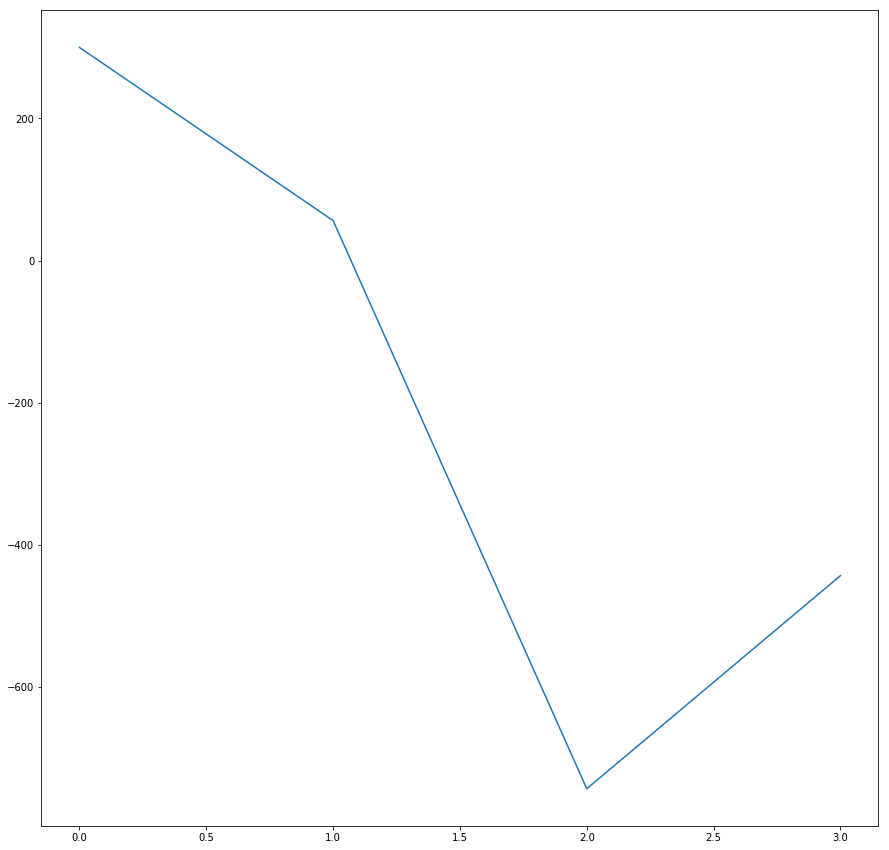

In [38]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
ax.plot(p.accumPL)

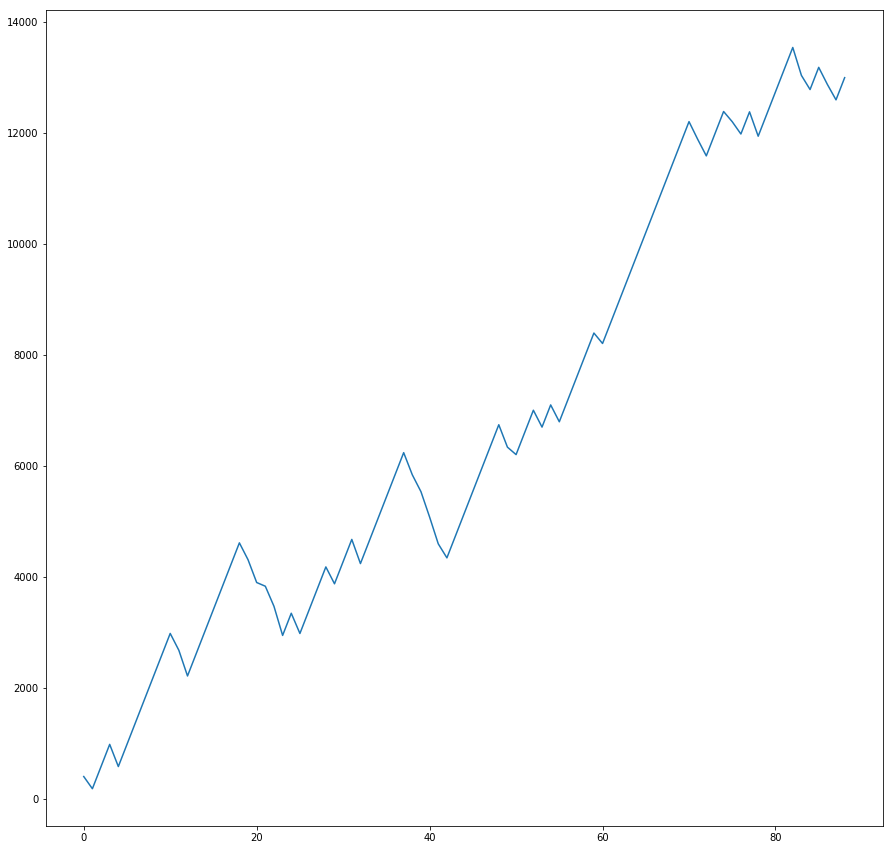

In [12]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
ax.plot(p.accumPL)

In [20]:
capital = 10000
lot_amount = INVERSE_PIP_RATIO*10
lots = capital / (lot_amount * 10)

for i in range(20,len(p.profitloss)):
    capital = capital + lot_amount* lots * p.profitloss[i] * PIP_RATIO
    print(capital)
    lots = capital / (lot_amount * 10)

13000.0
16900.0
21970.0
28561.0
15862.779400000045
20621.613220000057
26808.097186000046
34850.52634180006
16334.44169640163
21234.77420532212
27605.206466918753
35886.76840699438
24295.342211535128
31583.944874995665
41059.12833749436
53376.866838742666
35036.575392950646
45547.54801083584
59211.81241408659
76975.35613831256
100067.96297980634
130088.35187374824
169114.85743587272
219849.31466663454
285804.1090666249
371545.34178661235
483008.9443225961
627911.6276193749
816285.1159051873
1061170.6506767436
1379521.8458797666
1793378.3996436966
1334990.8806947605
1735488.1449031886
2256134.5883741453
2932974.9648863887
3812867.4543523053
4956727.690657997
6443745.997855395
5062851.230514965
6581706.599669455
8556218.579570292
11123084.153441379
14460009.399473794
18798012.21931593
24437415.88511071
15261166.220251651
19839516.086327147
25791370.91222529
33528782.18589288
43587416.841660745
12958539.027025677
10596197.362398887
13775056.571118552
10094361.45531564
7686856.248222841
999

In [13]:
capital = 10000
lot_amount = INVERSE_PIP_RATIO*10
lots = capital / (lot_amount * 10)

for i in range(len(p.profitloss)):
    capital = capital + lot_amount* lots * p.profitloss[i] * PIP_RATIO
    print(capital)
    lots = capital / (lot_amount * 10)


14000.0
10920.000000000015
15288.00000000002
21403.200000000026
12841.920000000016
17978.688000000024
25170.16320000003
35238.22848000005
49333.51987200007
69066.9278208001
96693.69894912015
67298.8144685877
36139.46336963163
50595.24871748428
70833.348204478
99166.68748626919
138833.36248077685
194366.7074730876
272113.3904623226
189390.91976177678
111551.25173968679
104077.31787312792
66401.32880305557
31540.631181451397
44156.88365403196
28039.621120310396
39255.46956843455
54957.65739580837
76940.72035413171
53550.74136647573
74971.03791306603
104959.45307829244
59239.11531738846
82934.76144434384
116108.66602208136
162552.13243091392
227572.98540327948
318602.17956459126
191161.30773875475
133048.27018617344
72178.68657599925
37359.688171737325
27907.687064287777
39070.76189000289
54699.06664600405
76578.69330440566
107210.17062616794
150094.2388766351
210131.93442728912
125238.63291866447
108394.03679110447
151751.65150754625
212452.31211056476
147866.80922895324
207013.532920534

In [23]:
capital = 10000
lots = 1
lot_amount = INVERSE_PIP_RATIO*10
for i in range(len(p.profitloss)):
    capital += lot_amount* lots * p.profitloss[i] * PIP_RATIO
    print(capital)

5990.000000000009
-2049.999999999998
950.0000000000018
3950.000000000002
-2700.0000000000045
299.99999999999545
-2740.000000000025
259.999999999975
-5210.000000000053
-2210.0000000000528
-8620.000000000076
-5620.000000000076
-12870.000000000106
-19350.000000000124
-16350.000000000124
-13350.000000000124
-10350.000000000124
-7350.000000000124
-4350.000000000124
-12390.000000000116
-9390.000000000116
-6390.000000000116
-3390.0000000001164
-390.0000000001164
-4836.0000000001
-1836.0000000001
1163.9999999998859
4163.999999999885
-1149.000000000131
1850.999999999869
4850.999999999869
7850.999999999869
4620.999999999851
7620.999999999851
10620.99999999985
13620.99999999985
10184.999999999844
13184.999999999844
16184.999999999844
19184.999999999844
22184.999999999844
25184.999999999844
28184.999999999844
31184.999999999844
34184.99999999984
37184.99999999984
40184.99999999984
43184.99999999984
46184.99999999984
49184.99999999984
52184.99999999984
55184.99999999984
52628.999999999796
55628.999

In [45]:
capital = 1000
lots = 1
lot_amount = 100000
for i in range(len(p.profitloss)):
    capital = capital + lots*capital*10*p.profitloss[i]*0.0001
    print(capital)

1196.0000000000007
982.5140000000015
855.5731912000009
941.1305103200029
887.7684103848582
893.8940124165124
818.9856941760081
696.3835357578603
832.8747087664013
916.1621796430434
1095.7299668530804
989.1154410782755
1084.0705234217903
780.2055557066601
735.655818475809
666.2099092116935
796.7870514171858
732.4863363678205
643.3427492318583
537.3198641584491
642.6345575335055
642.1847133432319
768.0529171585058
844.8582088743582
807.5154760421127
969.0185712505372
885.586072265868
812.0824282678032
971.250584208293
862.5676438353869
871.5383473312762
1045.8460167975336
937.600954058988
849.6539845682555
1016.1861655436342
928.7941553068822
1110.8378097470318
1333.0053716964408
1594.274424548944
1913.1293094587365
2288.1026541126503
2333.8647071949085
2084.8413429372126
1803.3877616406876
1765.6969574223986
1942.2666531646425
1739.6882412395717
2087.62588948749
2090.339803143823
2508.4077637725923
2143.4344341436786
2357.7778775580514
2218.9047605698834
1936.4381845493392
1506.93619521

11960.000000000007
10175.000000000015
8883.000000000011
9883.000000000035
9316.000000000027
9385.000000000013
8547.000000000007
7050.000000000015
9010.000000000022
10010.000000000045
11970.000000000051
10997.00000000005
11957.000000000055
9154.000000000033
8583.000000000022
7639.000000000033
9599.00000000004
8792.00000000006
7575.000000000081
5927.000000000098
7887.000000000105
7880.000000000103
9840.00000000011
10840.000000000133
10398.000000000146
12398.00000000017
11537.000000000191
10707.000000000216
12667.000000000222
11548.00000000024
11652.000000000255
13652.000000000278
12617.000000000271
11679.000000000276
13639.000000000284
12779.00000000029
14739.000000000295
16739.00000000032
18699.000000000327
20699.000000000353
22659.00000000036
22859.000000000382
21792.000000000386
20442.00000000038
20233.000000000386
21233.000000000407
20190.000000000415
22190.00000000044
22203.000000000437
24203.000000000462
22748.000000000455
23748.000000000477
23159.00000000048
21886.00000000049
1966

In [25]:
pair = 'gbpjpy'
year='2019'
time_frame = "M1"

download_hist_data(year=year,month=1,pair=pair, platform=Platform.META_TRADER, time_frame=TimeFrame.ONE_MINUTE, verbose=False)

file_name = 'DAT_MT_{}_{}_{}.zip'.format(pair.upper(), time_frame,year)
file_name_csv = 'DAT_MT_{}_{}_{}.csv'.format(pair.upper(), time_frame,year)



data.columns = ['Date','Time','Open','High','Low','Close','Volume']

FileNotFoundError: [Errno 2] No such file or directory: 'DAT_MT_GBPJPY_M1_2019.zip'

In [62]:
archive = zipfile.ZipFile("DAT_MT_GBPJPY_M1_201901.zip", 'r')
data = pd.read_csv(archive.open("DAT_MT_GBPJPY_M1_201901.csv"), header=None)

In [63]:
data

,0,1,2,3,4,5,6
0,2019.01.01,17:06,139.702,139.727,139.680,139.721,0
1,2019.01.01,17:08,139.685,139.685,139.684,139.684,0
2,2019.01.01,17:09,139.680,139.731,139.679,139.727,0
3,2019.01.01,17:12,139.493,139.629,139.493,139.629,0
4,2019.01.01,17:13,139.629,139.630,139.552,139.629,0
...,...,...,...,...,...,...,...
32021,2019.01.31,23:54,142.541,142.549,142.540,142.544,0
32022,2019.01.31,23:55,142.544,142.547,142.537,142.545,0
32023,2019.01.31,23:56,142.545,142.547,142.539,142.546,0
32024,2019.01.31,23:57,142.542,142.545,142.537,142.545,0


In [64]:
data.columns = ['Date','Time','Open', 'High', 'Low', 'Close', 'Volume']

In [ ]:


Time, Date, Open, High, Low, Close, Volume = time_convertor(data,30)

week_day = []
for i in range(len(Time)):
    day = Date[i].split('.')[2]
    month = Date[i].split('.')[1]
    year = Date[i].split('.')[0]
    week_day.append(calendar.weekday(int(year), int(month), int(day)))

Time = np.array(Time)  
Open = np.array(Open)  
High =  np.array (High)
Low =  np.array(Low)
Close =  np.array(Close)
#Ask = np.array(Ask)
week_day = np.array(week_day)

l = np.where(np.logical_or(week_day == 5, week_day == 6))

Time = np.delete(Time, l)  
Open = np.delete(Open, l)  
High =  np.delete (High, l)
Low =  np.delete(Low, l)
Close =  np.delete(Close, l)
Volume = np.delete(Volume, l)
#Ask = np.delete(Ask, l)

data = pd.DataFrame(list(zip(Time, Open, High, Low, Close, Volume)),
            columns=['Time','Open', 'High', 'Low', 'Close', 'Volume'])